
# Color scheme matching between images with LUTs


The goal of this notebook is to get an insight of how color LUTs work and how to use different algorithms to analyze and create image looks. The algorithms could be further enhanced, but the scope of this notebook is to keep it more simple.

As an example a LUT is created that aims to transfer the look of a target image to the input image.

This notebook is also capable of matching product images for example jewelry. Here it helps if the products are already cut out and in front of a 100% white background. In this case the variable "white_background" should be set to "True". 

Copyright [2020] [Andreas Jörg, aj-commercial]

SPDX-License-Identifier: Apache-2.0

In [1]:
%matplotlib notebook

# Import the libraries and define functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import matplotlib.cbook as cbook
from sklearn import neighbors
from sklearn import neighbors
import imageio
from mpl_toolkits.mplot3d import Axes3D
import colorsys
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment



def create_lut(size=8):
    LUT = []
    a = size -1
    for k in range(size):
        for j in range(size):
            for i in range(size):
                LUT.append([i / a, j / a, k / a])
    
    LUT = np.asarray(LUT)      
    return LUT


def list_to_lut(input_list, target_list,size=8,exp=2,frac=1):
    Target = np.asarray(target_list)
    Input = np.asarray(input_list)
    LUT_size = size
    a = LUT_size - 1
    LUT = []
    for k in range(LUT_size):
        for j in range(LUT_size):
            for i in range(LUT_size):
                LUT.append([i / a, j / a, k / a])
    
    LUT = np.asarray(LUT)
    for i in range(LUT.shape[0]):
        counter = 0
        denominator = 0
        for j in range(Input.shape[0]):
            if (np.linalg.norm(Target[j]-Input[j]))>0:
                counter = counter + 1/(np.sqrt(abs(np.sum((LUT[i]-Input[j])**2, axis=0)))**exp)*(Target[j]-Input[j])
                denominator = denominator+1/(np.sqrt(abs(np.sum((LUT[i]-Input[j])**2, axis=0)))**exp)
            
        LUT[i] = LUT[i] + (counter/denominator)*frac
        
    return LUT


class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        global coords_inp
        global coords_tar
        if event.inaxes == ax:
            coords_inp.append((event.xdata, event.ydata))
        if event.inaxes == ax2:
            coords_tar.append((event.xdata, event.ydata))    
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()
        return coords
    
def write_LUT(LUT, name):

    filename = name
    output = filename + '.cube'
    file = open(output, "w")
    file.write('TITLE "'+str(name)+'"\n')
    file.write('LUT_3D_SIZE 8')
    file.write('\n')
    file.write('\n')
    for i in range(len(LUT)):
        bstr = str(int(LUT[i][0]*10000) / 10000) + ' ' + str(int(LUT[i][1]*10000) / 10000) + ' ' + str(int(LUT[i][2]*10000) / 10000) + '\n'
        file.write(bstr)
    file.close()
    # np.savetxt(output, LUT, fmt="%2.4f", delimiter=" ")
    return output

# Create, write and visualize a neutral LUT, that does not change the image

<IPython.core.display.Javascript object>


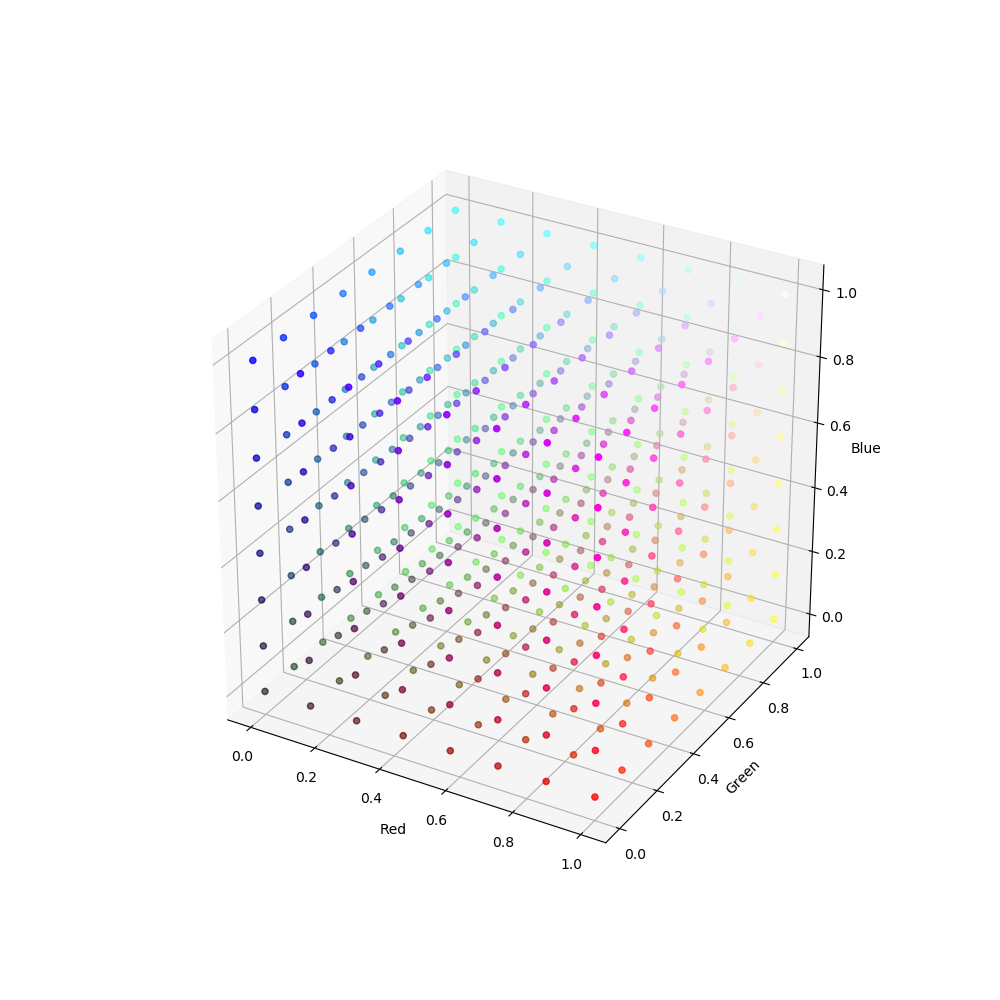

In [3]:
###############################
display_index = False                # choose if the indices of the colors should be displayed
###############################
LUT_neutral = create_lut(size=8)

write_LUT(LUT_neutral, 'neutral')

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(LUT_neutral[:,0],LUT_neutral[:,1], LUT_neutral[:,2], c=LUT_neutral)

if display_index == True:
    for i in range(LUT_neutral.shape[0]):
        ax.text(LUT_neutral[i,0], LUT_neutral[i,1], LUT_neutral[i,2], str(i))
    
plt.show()

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

# Load the images

In [24]:
img_inp = imageio.imread('input.jpg')/255
img_tar = imageio.imread('target.jpg')/255

# Manual selection of corresbonding colors between the two images. This part can be skipped until "Automatically..."

<IPython.core.display.Javascript object>


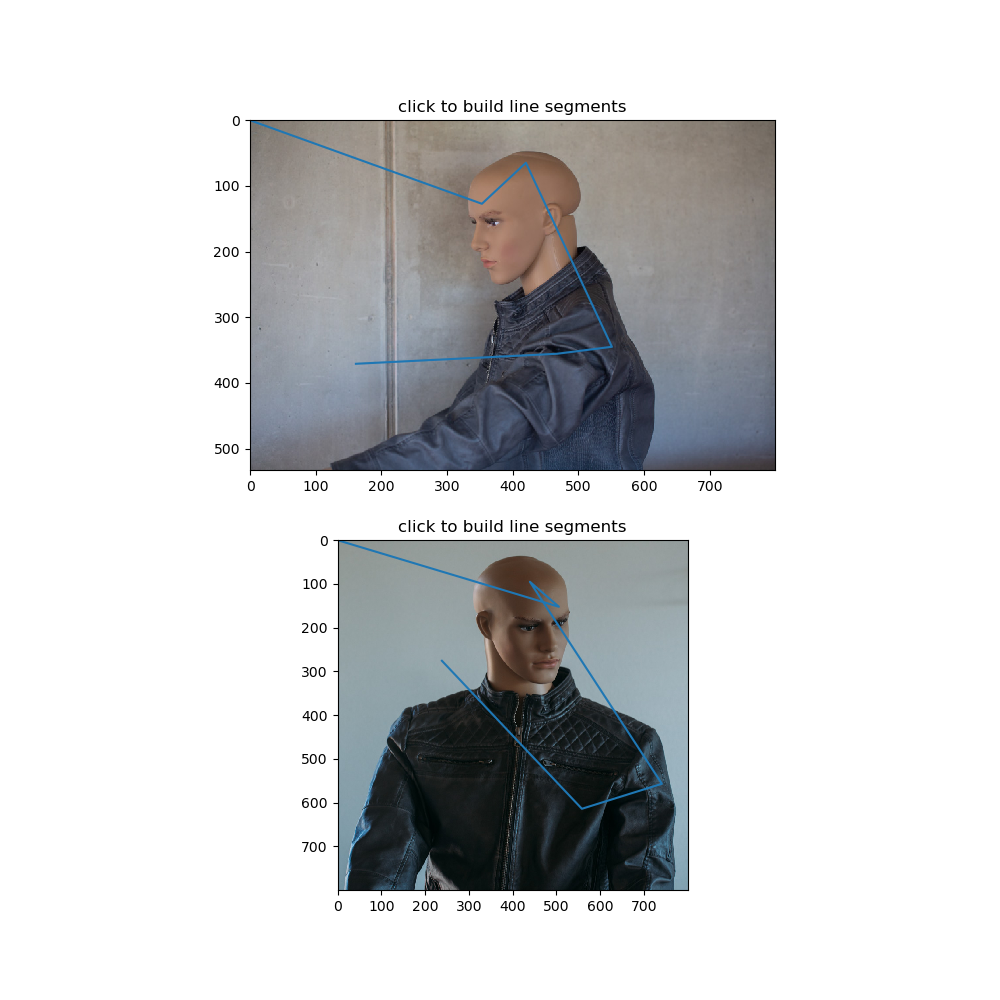

In [28]:
coords_inp = []
coords_tar = []


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
ax.set_title('click to build line segments')
ax.imshow(img_inp)
line, = ax.plot([0], [0])  # empty line
linebuilder = LineBuilder(line)

ax2 = fig.add_subplot(212)
ax2.set_title('click to build line segments')
ax2.imshow(img_tar)
line2, = ax2.plot([0], [0])  # empty line
linebuilder = LineBuilder(line2)

plt.show()

In [26]:
LUT_size = 8

# Create the LUT

In [ ]:
def coordtocolor(img,coords):
    colors = []
    for i in range(len(coords)):
        colors.append(img[int(coords[i,1]),int(coords[i,0])])
    return colors


coords_inp = np.asarray(coords_inp)
coords_tar = np.asarray(coords_tar)

input_list = coordtocolor(img_inp,coords_inp)
target_list = coordtocolor(img_tar, coords_tar)

LUT = list_to_lut(input_list, target_list, LUT_size)

write_LUT(LUT,'manual_LUT')

# Show the colors of the input image (blue) and the colors of the target image (green) that have been selected. The red lines indicate to which color of the target image the input should be moved.

<IPython.core.display.Javascript object>


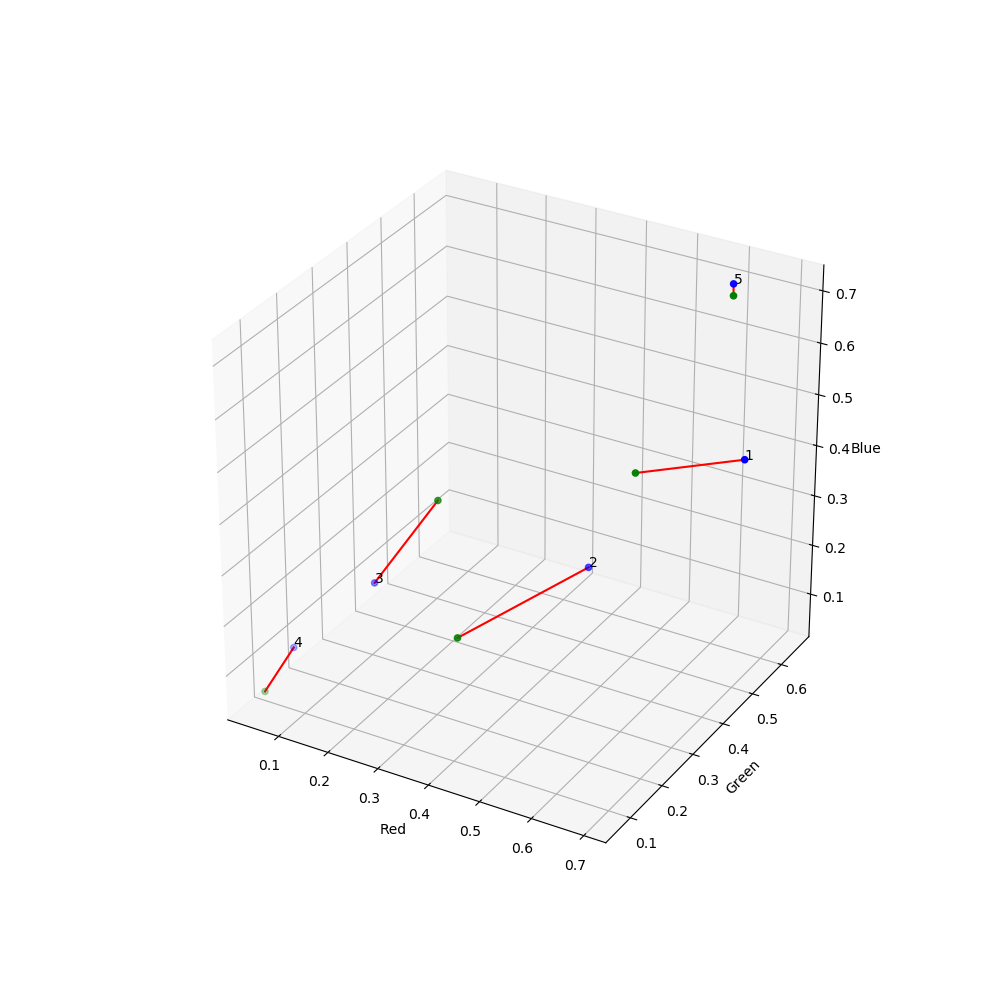

In [30]:
input_list = np.asarray(input_list)
target_list = np.asarray(target_list)

    
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

for x1,y1,z1,x2,y2,z2 in zip(input_list[:,0],input_list[:,1],input_list[:,2], target_list[:,0],target_list[:,1],target_list[:,2]):
    ax.plot([x1,x2], [y1,y2], [z1,z2], color = 'r')
ax.scatter(input_list[:,0],input_list[:,1],input_list[:,2], color = 'b')    
ax.scatter(target_list[:,0],target_list[:,1],target_list[:,2], color = 'g') 
for i in range(input_list.shape[0]):
    ax.text(input_list[i,0], input_list[i,1], input_list[i,2], str(i+1))
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()


# Show the LUT as vectors. The length of the vectors indicate how much the color will be moved by the LUT

<IPython.core.display.Javascript object>


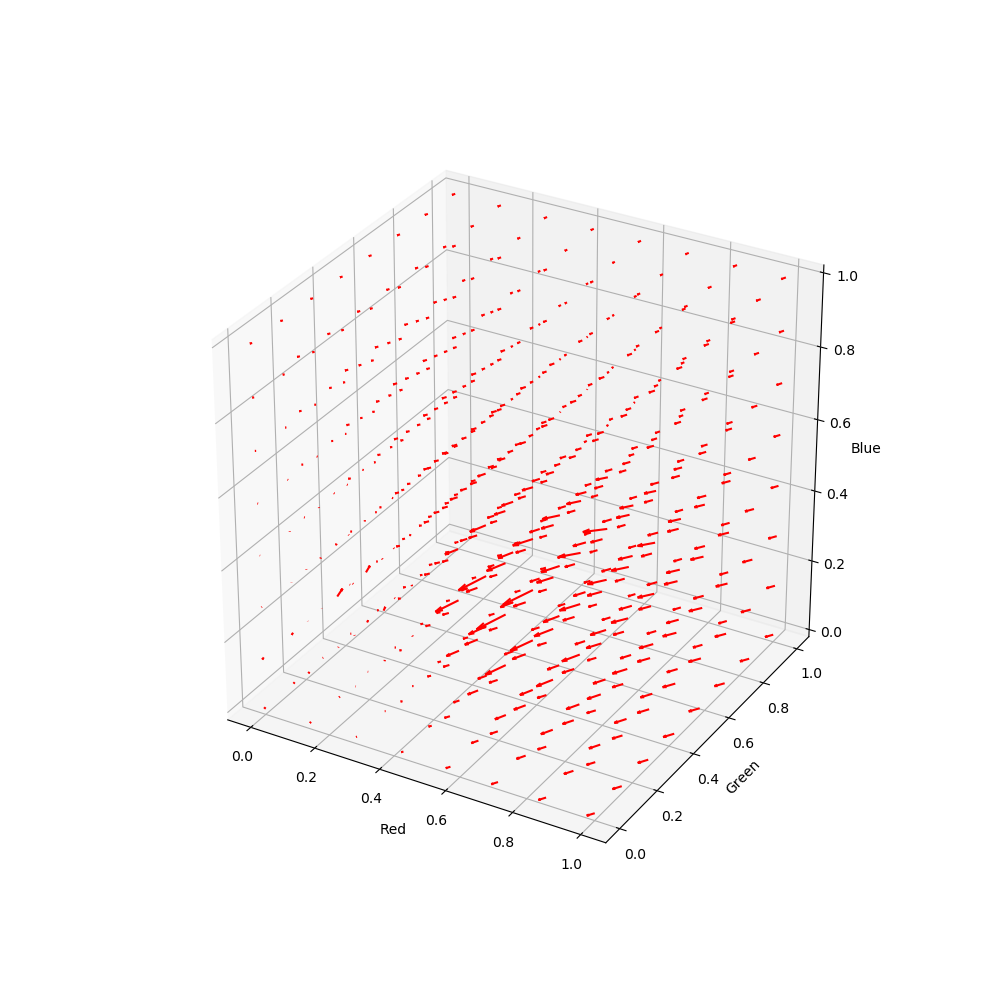

In [31]:
LUT_base = create_lut(size=LUT_size)
LUT_diff = LUT-LUT_base
lengths = np.zeros(LUT_diff.shape[0])

lengths_lut = np.sqrt(LUT_diff[:,0]**2 + LUT_diff[:,1] **2 + LUT_diff[:,2]**2)

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

for x1,y1,z1,u1,v1,w1,l in zip(LUT_base[:,0],LUT_base[:,1],LUT_base[:,2], LUT_diff[:,0],LUT_diff[:,1],LUT_diff[:,2],lengths_lut):
    ax.quiver(x1, y1, z1, u1, v1, w1, length=l*2, color = 'r')


    
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()


# Automatically get a colorscheme from the input and the target image. Then try to find a partner in the scheme of the target list for each element in the input list

<IPython.core.display.Javascript object>


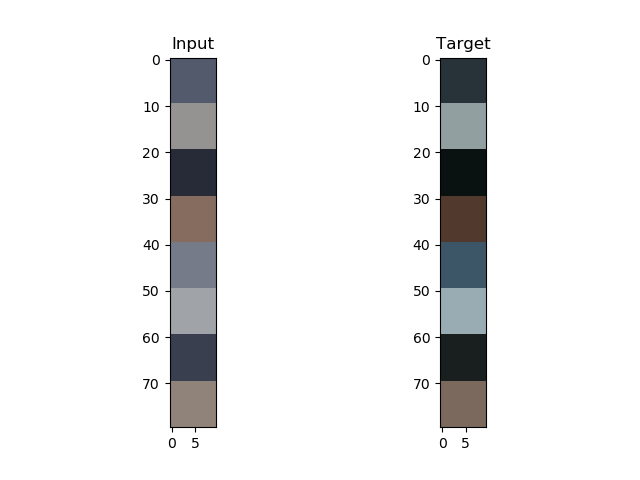

Text(0.5, 1.0, 'Target')

In [32]:
def cluster_colors(img,n_colors,white_background):
    pixel_list = np.reshape(img, (img.shape[0] * img.shape[1], 3))
    if white_background == True:
        white_pixels = np.all(pixel_list == [1, 1, 1], axis=-1)
        non_white_pixels = ~white_pixels
        pixel_list = pixel_list[non_white_pixels]
    pixel_subset = shuffle(pixel_list, random_state=0)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(pixel_subset)
    colors = kmeans.cluster_centers_
    return colors

def get_color_palette(img,n_colors):
    color_thief = ColorThief(img)
    palette = color_thief.get_palette(color_count=n_colors)
    palette = np.asarray(palette)/255
    return palette

def find_partners(input_list,target_list, mode):
    if mode == "RGB":
        cost_matrix = distance_matrix(input_list, target_list)
    else:
        cost_matrix = cost_matrix_hsv(input_list, target_list)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    sorted_inp_list = np.zeros((row_ind.shape[0],3))
    sorted_tar_list = np.zeros((row_ind.shape[0],3))
    for i in range (row_ind.shape[0]):
            sorted_inp_list[i] = input_list[row_ind[i]]
            sorted_tar_list[i] = target_list[col_ind[i]]
            #print(cost_matrix[row_ind[i],col_ind[i]])
    return sorted_inp_list, sorted_tar_list

def cost_matrix_hsv(input_list,output_list, weights = [2,2,2]):
    cost_matrix_hsv = np.zeros((input_list.shape[0],target_list.shape[0]))
    for i in range (input_list.shape[0]):
        for j in range (target_list.shape[0]):
            input_hsv = colorsys.rgb_to_hsv(input_list[i,0],input_list[i,1],input_list[i,2])
            target_hsv = colorsys.rgb_to_hsv(target_list[j,0],target_list[j,1],target_list[j,2])
            cost = (min(abs(input_hsv[0]-target_hsv[0]),1-abs(input_hsv[0]-target_hsv[0])))**weights[0]
            for k in range (2):
                cost = (abs(input_hsv[k+1] - target_hsv[k+1]))**weights[k+1] + cost
            cost_matrix_hsv[i,j] = cost
    return cost_matrix_hsv
    
    
def find_partners_skip(input_list,target_list,mode):
    if mode == "RGB":
        cost_matrix = distance_matrix(input_list, target_list)
    else:
        cost_matrix = cost_matrix_hsv(input_list, target_list)
    input_list_out = []
    target_list_out = []
    col_mins = np.amin(cost_matrix, axis=0)
    for i in range (cost_matrix.shape[0]):
        index = np.argmin(cost_matrix)
        index = np.unravel_index(index, cost_matrix.shape)
        if cost_matrix[index] <= col_mins[index[0]]:
            input_list_out.append(input_list[index[0]])
            target_list_out.append(target_list[index[1]])
        cost_matrix[index[0],:] = 5
        cost_matrix[:,index[1]] = 5
    return np.asarray(input_list_out), np.asarray(target_list_out)

def show_colors(color_list):
    out_img = np.zeros((10,10,3))
    out_img[:,:] = color_list[0]
    for i in range (color_list.shape[0]-1):
        out_conc = np.zeros((10,10,3))
        out_conc[:,:] = color_list[i+1]
        out_img = np.concatenate((out_img,out_conc),axis=0)
    return out_img


            
    


###############################################
white_background = False                          # set true when the subject is cut out in front of white background
mode = "HSV"                                      # set to "RGB" when the distances should be measrued in RGB space
###############################################
input_list = cluster_colors(img_inp,8,white_background)
target_list = cluster_colors(img_tar,8,white_background)


input_list, target_list = find_partners(input_list,target_list,mode)
input_colors = show_colors(input_list)
target_colors = show_colors(target_list)

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(input_colors)
a.set_title('Input')

a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(target_colors)

a.set_title('Target')



# By running the following cell the n worst matching pairs get removed

<IPython.core.display.Javascript object>


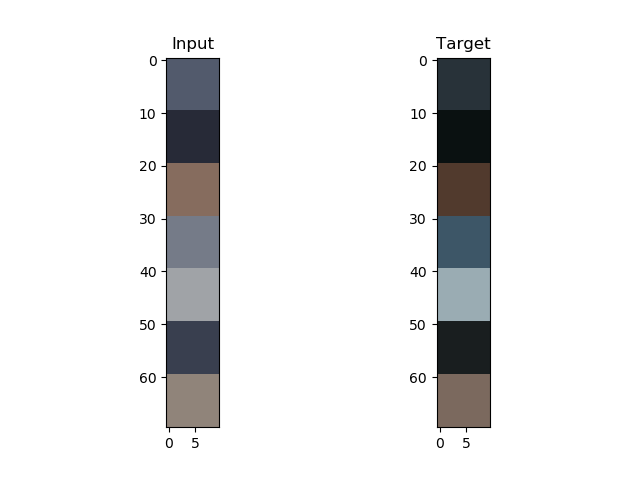

Text(0.5, 1.0, 'Target')

In [33]:
n = 1               # number of worst matches that should be removed

def delete_largest_diff(input_list, target_list,n):
    difference = np.zeros((input_list.shape[0]))
    difference = np.diag(cost_matrix_hsv(input_list,target_list))
    indices = difference.argsort()
    input_list = np.delete(input_list, indices[-n:], axis=0)
    target_list = np.delete(target_list, indices[-n:], axis=0)
    return input_list, target_list


input_list, target_list = delete_largest_diff(input_list, target_list,n)
input_colors = show_colors(input_list)
target_colors = show_colors(target_list)

fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(input_colors)
a.set_title('Input')

a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(target_colors)

a.set_title('Target')


# Show the colors of the input image (blue) and the colors of the target image (green) that have been selected. The red lines indicate to which color of the target image the input should be moved.

<IPython.core.display.Javascript object>


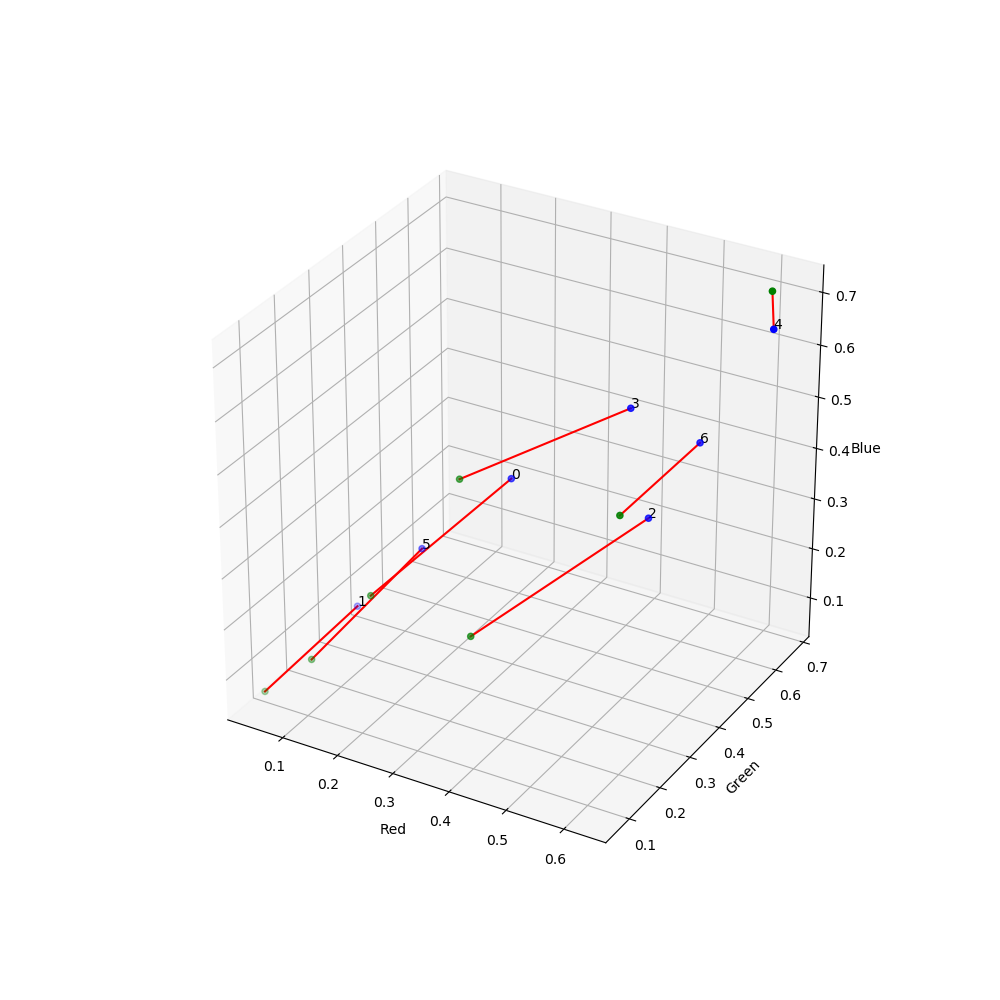

In [36]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

for x1,y1,z1,x2,y2,z2 in zip(input_list[:,0],input_list[:,1],input_list[:,2], target_list[:,0],target_list[:,1],target_list[:,2]):
    ax.plot([x1,x2], [y1,y2], [z1,z2], color = 'r')
ax.scatter(input_list[:,0],input_list[:,1],input_list[:,2], color = 'b')    
ax.scatter(target_list[:,0],target_list[:,1],target_list[:,2], color = 'g') 
for i in range(input_list.shape[0]):
    ax.text(input_list[i,0], input_list[i,1], input_list[i,2], str(i))
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

# Possibility to manually enhance the LUT by deleting or adding reference points.

In [ ]:
####################################################################
#custom input to add and remove reference points
remove = []                       # delete in the input list as well as in the target list
add_const = [[0,0,0],[1,1,1]]     # add fix-points
####################################################################
add_const = np.asarray(add_const)
input_list_new = np.delete(input_list, remove, axis=0)
target_list_new = np.delete(target_list, remove, axis=0)

if add_const.shape[0]>0:
    input_list_new = np.concatenate((input_list_new,add_const),axis=0)
    target_list_new = np.concatenate((target_list_new,add_const),axis=0)

LUT = list_to_lut(input_list_new, target_list_new,LUT_size,exp=2)

write_LUT(LUT,'automatic_LUT')

# Show the input and target colors after custom enhancements

<IPython.core.display.Javascript object>


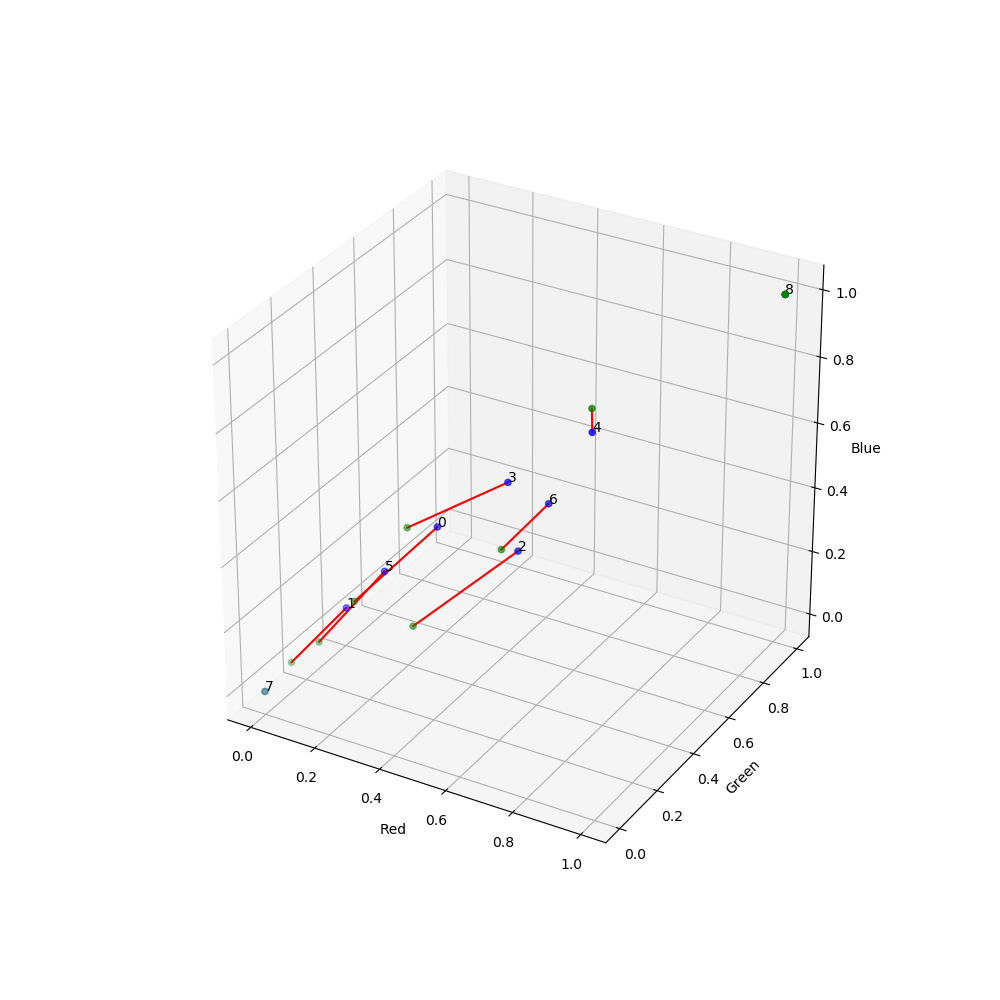

In [37]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

for x1,y1,z1,x2,y2,z2 in zip(input_list_new[:,0],input_list_new[:,1],input_list_new[:,2], target_list_new[:,0],target_list_new[:,1],target_list_new[:,2]):
    ax.plot([x1,x2], [y1,y2], [z1,z2], color = 'r')
ax.scatter(input_list_new[:,0],input_list_new[:,1],input_list_new[:,2], color = 'b')    
ax.scatter(target_list_new[:,0],target_list_new[:,1],target_list_new[:,2], color = 'g') 
for i in range(input_list_new.shape[0]):
    ax.text(input_list_new[i,0], input_list_new[i,1], input_list_new[i,2], str(i))
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

<IPython.core.display.Javascript object>


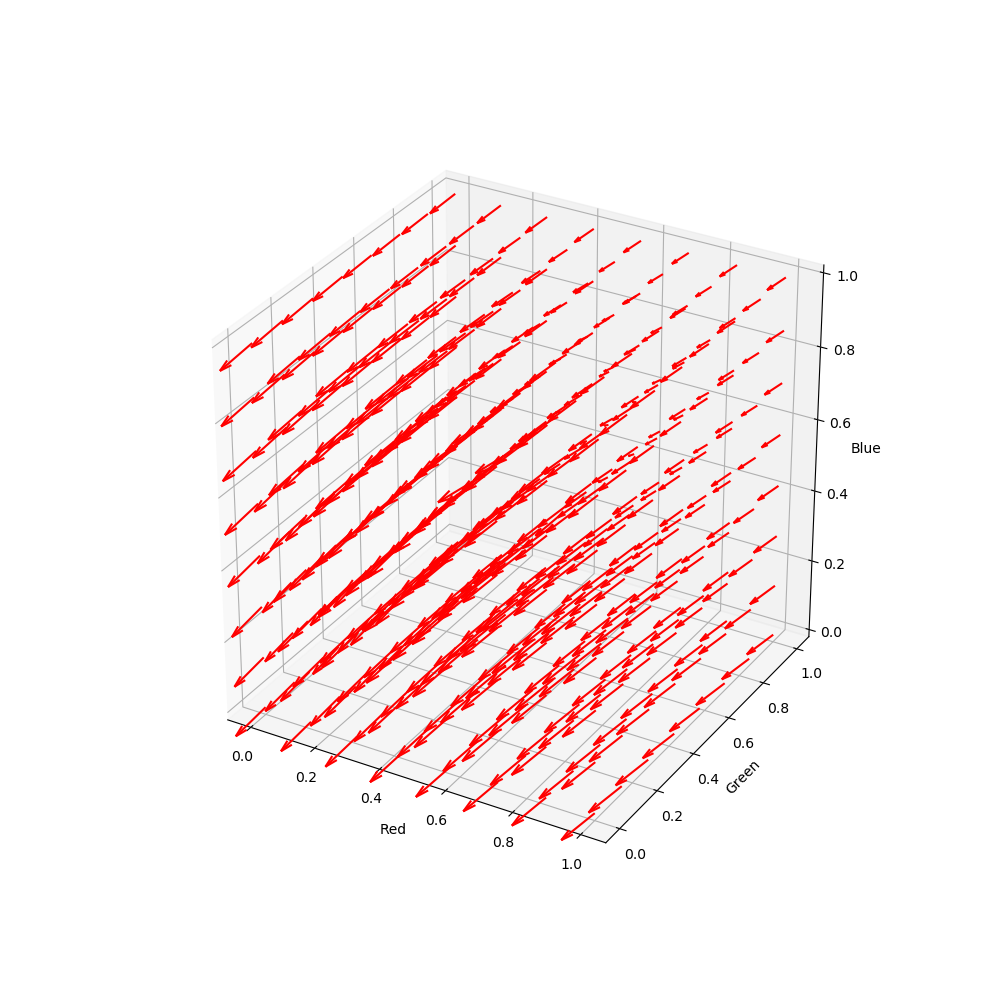

In [38]:
LUT_base = create_lut(size=LUT_size)
LUT_diff = LUT-LUT_base
lengths = np.zeros(LUT_diff.shape[0])

lengths_lut = np.sqrt(LUT_diff[:,0]**2 + LUT_diff[:,1] **2 + LUT_diff[:,2]**2)

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

for x1,y1,z1,u1,v1,w1,l in zip(LUT_base[:,0],LUT_base[:,1],LUT_base[:,2], LUT_diff[:,0],LUT_diff[:,1],LUT_diff[:,2],lengths_lut):
    ax.quiver(x1, y1, z1, u1, v1, w1, length=l*2, color = 'r')


    
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()

# The following function outlines an algorithm that creates an LUT from the same image in a "before" and "after" version

In [39]:

def img_to_lut(input_image, target_image):
    Target = target_image
    Input = input_image 

    safe = Target
    x = 0
    tR = []
    tG = []
    tB = []
    shape = Target.shape

    # differences on each pixel; here all pixels of the ixj array get sorted along
    # one dimension (i*j long) for both the input and the target image in the same
    # way. Afterwards for every color channel (tR, tG, TB) a list is created that
    # contains the difference between target value and input value.
    for i in range(shape[0]):
        for j in range(shape[1]):
            tR.append(Target[i, j, 0] - Input[i, j, 0])
            tG.append(Target[i, j, 1] - Input[i, j, 1])
            tB.append(Target[i, j, 2] - Input[i, j, 2])

            # here a list is created that sorts the input RGB Values along the pixel numbers
    # in the same order as above. So it starts with the first line on the left, once
    # the line is finished, counting continues on the next line left
    icolor = []
    for i in range(shape[0]):
        for j in range(shape[1]):
            icolor.append(Input[i, j, :])
    icolor = np.asarray(icolor)

    #interpolation = neighbors.RadiusNeighborsRegressor(radius = 0.06, weights='distance')

    LUT_size = 8
    a = LUT_size - 1
    # here the input LUT is created out of equally spaced RGB values in R^3
    LUT = []
    # LUT.append(['TITLE', '"test"', ''])
    # LUT.append(['LUT_3D_SIZE', str(LUT_size), ''])
    # LUT.append(['', '', ''])
    # LUT.append(['', '', ''])
    for k in range(LUT_size):
        for j in range(LUT_size):
            for i in range(LUT_size):
                LUT.append([i / a, j / a, k / a])

    # since we have all lists in the same order (icolor and the color differences tR,
    # tG, tB) we now can fit a function between icolor and the coresponding color
    # difference at each RGB coordinate. Afterwrds we predict the difference of the
    # LUT that is on a grit at this position

    interpolation = neighbors.KNeighborsRegressor(40, weights='distance')
    LUT = np.asarray(LUT)
    tRp = interpolation.fit(icolor, tR).predict(LUT)
    tGp = interpolation.fit(icolor, tG).predict(LUT)
    tBp = interpolation.fit(icolor, tB).predict(LUT)
    # print(tGp)
    for i in range(LUT_size ** 3):
        LUT[i, 0] = LUT[i, 0] + tRp[i]
        # print(tBp[i])
        LUT[i, 1] = LUT[i, 1] + tGp[i]
        LUT[i, 2] = LUT[i, 2] + tBp[i]

    LUT = LUT.clip(min=0)
    return LUT
